# Network analysis of patient flow

This notebook intend to use a **complex network** approach to **analyze the patient flow** through the municipalities in the Brazilian states. The first part of the analysis will be based on creating a network visualization, considering the centroids of municipalities as nodes, and the patient flow between them as edges. From this, we will apply some complex network techniques no analyze the hospitalization distribution into the studied Brazilian state. 

By analyzing the evolution of these data over the past 20 years for each Brazilian state, we can **evaluate the effectiveness of the regionalization process** in different regions of the country and in different moments of our recent history.

## Task Organization

1. Plot the patient flow network on the map   

2. Filter the flows to consider just relevant volume of patient displacements (> 10 patients, for example)

3. Improve the visualization: change the edge thickness according to the volume of the flow, for example
  
---

### Part 1: Plot the patient flow network on the map  

In [30]:

# choosing the Brazilian state (e.g. 'BA-29', 'SP-35', 'RJ-33') and year

UF = 'RJ'
uf_code = 33
UF_name = 'Rio de Janeiro'

year = 2017


In [31]:
import pandas as pd
import geopandas as gpd

# import the municipalities shapes
mun_df = gpd.read_file("../data/%s/%s_mun.shp"%(UF, UF))

# import the patient flow data
df = pd.read_csv("../data/%s/%s_sih_flow.csv"%(UF, UF))

# restrict to one specific year
df = df[df["year"]==year]

**Removing incoming/outcomming hospitalizations out from the choosen state**

In [32]:
df = df[df['mun_res']>uf_code*10000][df['mun_res']<(uf_code+1)*10000]
df = df[df['mun_cnes']>uf_code*10000][df['mun_cnes']<(uf_code+1)*10000]

<ipython-input-32-f35c2061d4d4>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['mun_cnes']>uf_code*10000][df['mun_cnes']<(uf_code+1)*10000]


In [33]:
# df.to_csv("%s_sih_flow.csv"%UF, index=False) # [arquivo usado na plataforma]s o arquivo não restringe ano, mas restringe origem e destino de fora do estado

**Plot the patient flow as a non spatial network**

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.from_pandas_edgelist(df, source = 'mun_res', target = 'mun_cnes',
                        edge_attr = 'nhospadm_total',create_using = nx.DiGraph())
# plt.figure(figsize=(14,12))
# nx.draw_networkx(graph, pos=nx.spring_layout(graph, k=0.1, weight='nhospadm_total'), node_size=20, with_labels=False)
# plt.show()

**Create dictionaries to favor the network creation process**

In [35]:
# fetch municipalities name and positions
mun_dict = {'name': {}, 'position': {}, 'hospitalization': {}}

mun_dict['name'] = {int(item[0]):item[1] for item in mun_df[['code', 'name']].values}
mun_dict['position'] = {int(item[0]):(item[1], item[2]) for item in mun_df[['code', 'centroid_x', 'centroid_y']].values}

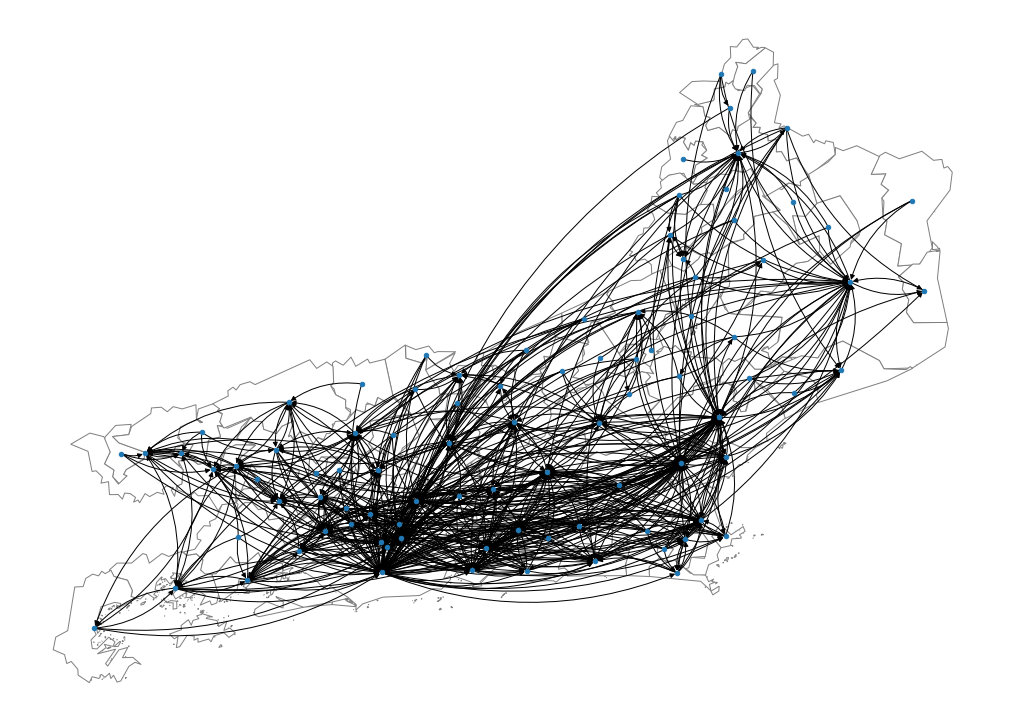

In [36]:
# plot the patient flow as a spatial network

fig, ax = plt.subplots(figsize=(18, 14))
gpd.GeoSeries(mun_df['geometry']).plot(ax=ax, color='white', edgecolor='gray')
nx.draw(graph, mun_dict['position'], node_size=20, connectionstyle='arc3,rad=0.2', with_labels=False)

plt.show()

### Part 2: Filter the flows according to the volume of patient displacements

##### Getting the number of hospitalizations for each municipality 

In [37]:
# get the number of hospitalizations each municipality had
hosp_per_mun = df[['mun_cnes', 'nhospadm_total']].groupby(
    by = ['mun_cnes'], as_index = False).sum()

mun_dict['hospitalization'] = {int(item[0]):item[1] for item in hosp_per_mun.values}
for code in mun_df['code']:
    if not code in mun_dict['hospitalization']:
        mun_dict['hospitalization'][code] = 0

In [38]:
df

year  uf_code  mun_cnes   mun_res  nhospadm_total
11513  2017       33    330010  330010.0            2734
11514  2017       33    330010  330110.0               2
11515  2017       33    330010  330260.0              41
11516  2017       33    330010  330380.0              18
11517  2017       33    330010  330440.0              19
...     ...      ...       ...       ...             ...
12277  2017       33    330630  330395.0              20
12278  2017       33    330630  330400.0               9
12279  2017       33    330630  330555.0               1
12280  2017       33    330630  330610.0               4
12281  2017       33    330630  330630.0            2741

[769 rows x 5 columns]

In [39]:
# get all flows with more than 0.01% of the total flows

percent = 0.01

total_num_flows = df['nhospadm_total'].sum()
min_num_flows = total_num_flows*percent*0.01

simple_flows = df[df['nhospadm_total']>min_num_flows]

print("Total hospitalizations sum:", int(total_num_flows))
print("%.2f%% of total hospitalizations: %.2f"%(percent, min_num_flows))
print(simple_flows.shape[0], "flows, each one greater than", int(min_num_flows), "patients")

Total hospitalizations sum: 191324
0.01% of total hospitalizations: 19.13
198 flows, each one greater than 19 patients


**Show only the flows with more than 0.01% of the patient displacements**

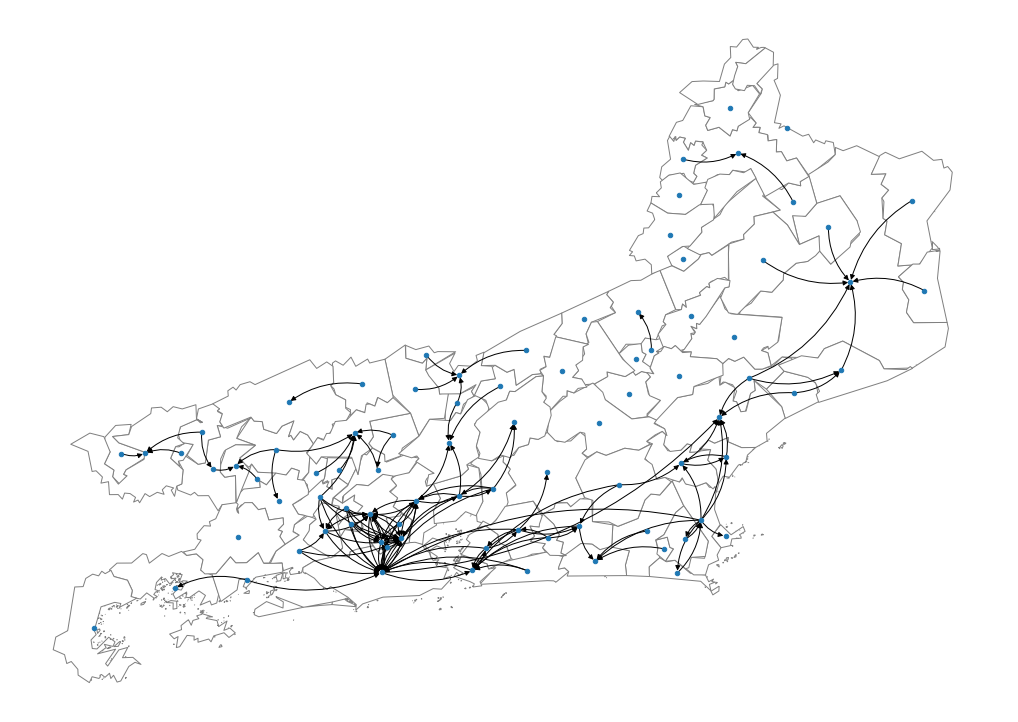

In [40]:
simple_graph = nx.from_pandas_edgelist(simple_flows, source = 'mun_res', target = 'mun_cnes',
                        edge_attr = 'nhospadm_total',create_using = nx.DiGraph())
fig, ax = plt.subplots(figsize=(18, 14))
gpd.GeoSeries(mun_df['geometry']).plot(ax=ax, color='white', edgecolor='gray')
nx.draw(simple_graph, mun_dict['position'], node_size=20, connectionstyle= 'arc3,rad=0.2', with_labels=False)
plt.show()

### Part 3: Improve the visualization
 - Change the edge thickness according to the volume of the flow
 - Change the edge color and opacity
 - Change the node size according to the volume of patients the municipality received

(-45.088514056418944,
 -40.706256937202156,
 -23.49920924505,
 -20.633109017949998)

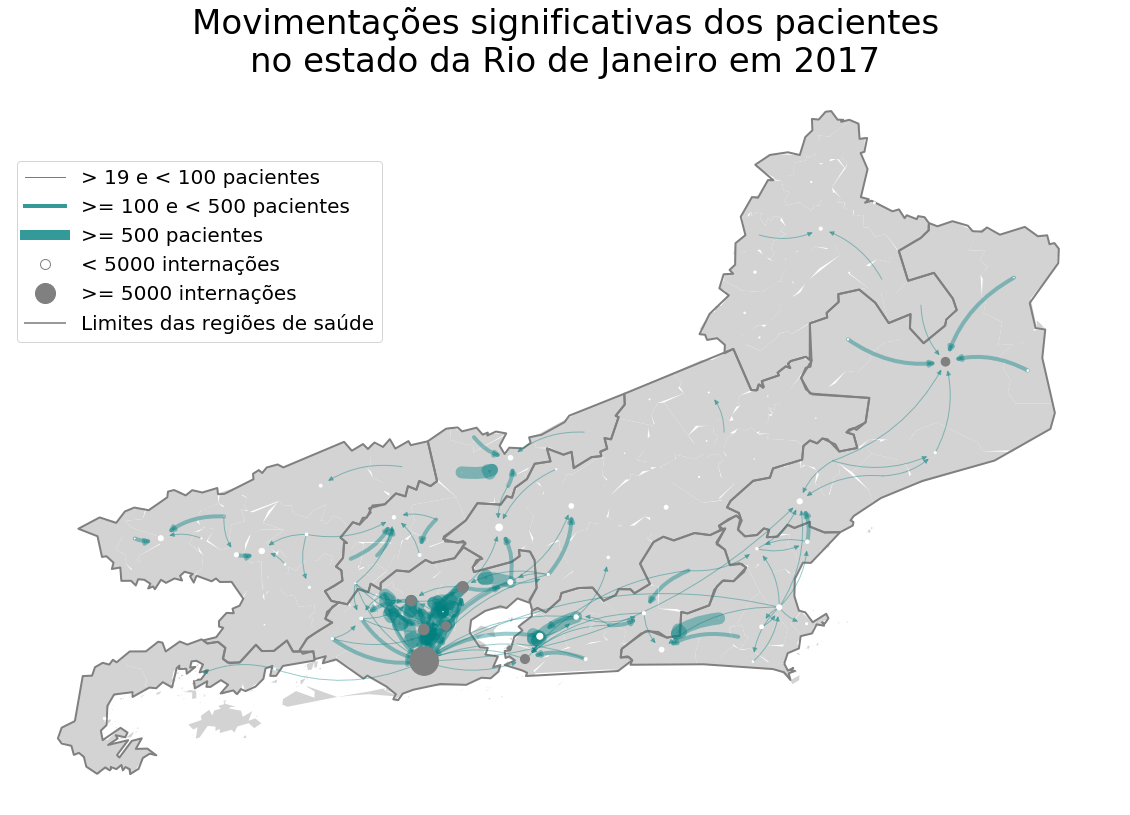

In [41]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(20, 16))
# fig.set_facecolor('whitesmoke')
gpd.GeoSeries(mun_df['geometry']).plot(ax=ax, color='lightgray', zorder=1)
gpd.read_file("../data/%s/regions/regions_2017.shp"%(UF)).plot(ax=ax, facecolor='none', edgecolor='gray', zorder=1, lw=2)

# nodes
all_nodes = simple_graph.nodes

nsmall = [node for node in all_nodes if mun_dict['hospitalization'][node] < 5000]
nlarge = [node for node in all_nodes if mun_dict['hospitalization'][node] >= 5000]

node_size_small = [mun_dict['hospitalization'][code]*0.01 for code in nsmall]
node_size_large = [mun_dict['hospitalization'][code]*0.01 for code in nlarge]

nx.draw_networkx_nodes(simple_graph, mun_dict['position'], node_size=node_size_small, nodelist=nsmall,  node_color='w')
nx.draw_networkx_nodes(simple_graph, mun_dict['position'], node_size=node_size_large, nodelist=nlarge,  node_color='gray')

# edges
all_edges = simple_flows.to_numpy().T[[2, 3, 4]].T

esmall = [(v, u) for (u, v, d) in all_edges if d < 100]
emedium = [(v, u) for (u, v, d) in all_edges if d >= 100 and d < 500]
elarge = [(v, u) for (u, v, d) in all_edges if d >= 500]

nx.draw_networkx_edges(simple_graph, mun_dict['position'], edgelist=esmall, alpha=0.4, width=1, edge_color='teal', connectionstyle= 'arc3,rad=0.2')
nx.draw_networkx_edges(simple_graph, mun_dict['position'], edgelist=emedium, alpha=0.4, width=4, edge_color='teal', connectionstyle= 'arc3,rad=0.2')
nx.draw_networkx_edges(simple_graph, mun_dict['position'], edgelist=elarge, alpha=0.4, width=12, edge_color='teal', connectionstyle= 'arc3,rad=0.2')

edge_lines = [Line2D([0, 1], [0, 2], color='teal', alpha=0.8, lw=w) for w in [1, 4, 10]]
node_lines = [Line2D(range(1), range(1), color='w', marker='o', markerfacecolor=clr, ms=s, mec='gray') for s, clr in [(10, 'w'), (20, 'gray')]]
regions_line = [Line2D([0, 1], [0, 2], color='gray', alpha=0.8, lw=2)]

plt.legend(edge_lines+node_lines+regions_line, 
           ['> %d e < 100 pacientes'%min_num_flows, '>= 100 e < 500 pacientes', '>= 500 pacientes', 
            '< 5000 internações', '>= 5000 internações', 'Limites das regiões de saúde'], fontsize = '20', loc='upper left', bbox_to_anchor=(0, 0.9)) 
#            ['< 100 patients displacement', '>= 100 and < 500 patients', '>= 500 patients', '< 5000 hospitalizations', '>= 5000 hospitalizations', 'Limits of Health Regions'], loc=2, fontsize = '18')

plt.title('Movimentações significativas dos pacientes\nno estado da ' + UF_name + ' em ' + str(year), fontsize = '34')
# plt.title('Significant Patient Displacements (> '+str(int(min_num_flows))+' per link)\n in the state of ' + UF + ', ' + str(year), fontsize = '40')
ax.axis("off")
# plt.savefig('/home/gabriely/Projetos/qualificacao/figuras/viz_%s.png'%(UF.lower()), bbox_inches='tight')